# *Лабортаторная работа №1 Глобин Дмитрий Алексеевич Б9122-01.03.02мкт*

**Миша я тебя люблю**

### Загруз0чка библиотек по базе

In [41]:
import pandas as pd  
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
from scipy import stats  
import requests  
import io 
import warnings

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

warnings.filterwarnings('ignore')

## Базированная загруз0чка датасета
 
**Загружает датасет с недвижимостью Калифорнии, источник: GitHub репозиторий с открытыми данными**
## насколько принципиально качать было с hugging face? я прост привык искать датасеты на гитах валяющиеся ибо так проще качать чучут если что не бей по попи я умею я могу

In [35]:
def download_dataset():
   
    url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
    
    # Отправляем GET-запрос к URL
    response = requests.get(url)
    response.raise_for_status()  # Проверяем успешность запроса
    
    # Читаем CSV данные в DataFrame (таблицу pandas)
    df = pd.read_csv(io.StringIO(response.text))
    return df

# Загружаем данные
df = download_dataset()


### Инфо о датасете

In [36]:
print(f" Размер датасета: {df.shape}") 
print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")

print("\n Первые 5 строк датасета:")
print(df.head())

print("\n Информация о столбцах и типах данных:")
print(df.info())

print("\n Статистическое описание числовых признаков:")
print(df.describe())

print("\n Пропущенные значения:")
print(df.isnull().sum())

 Размер датасета: (20640, 10)
Количество строк: 20640
Количество столбцов: 10

 Первые 5 строк датасета:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462         

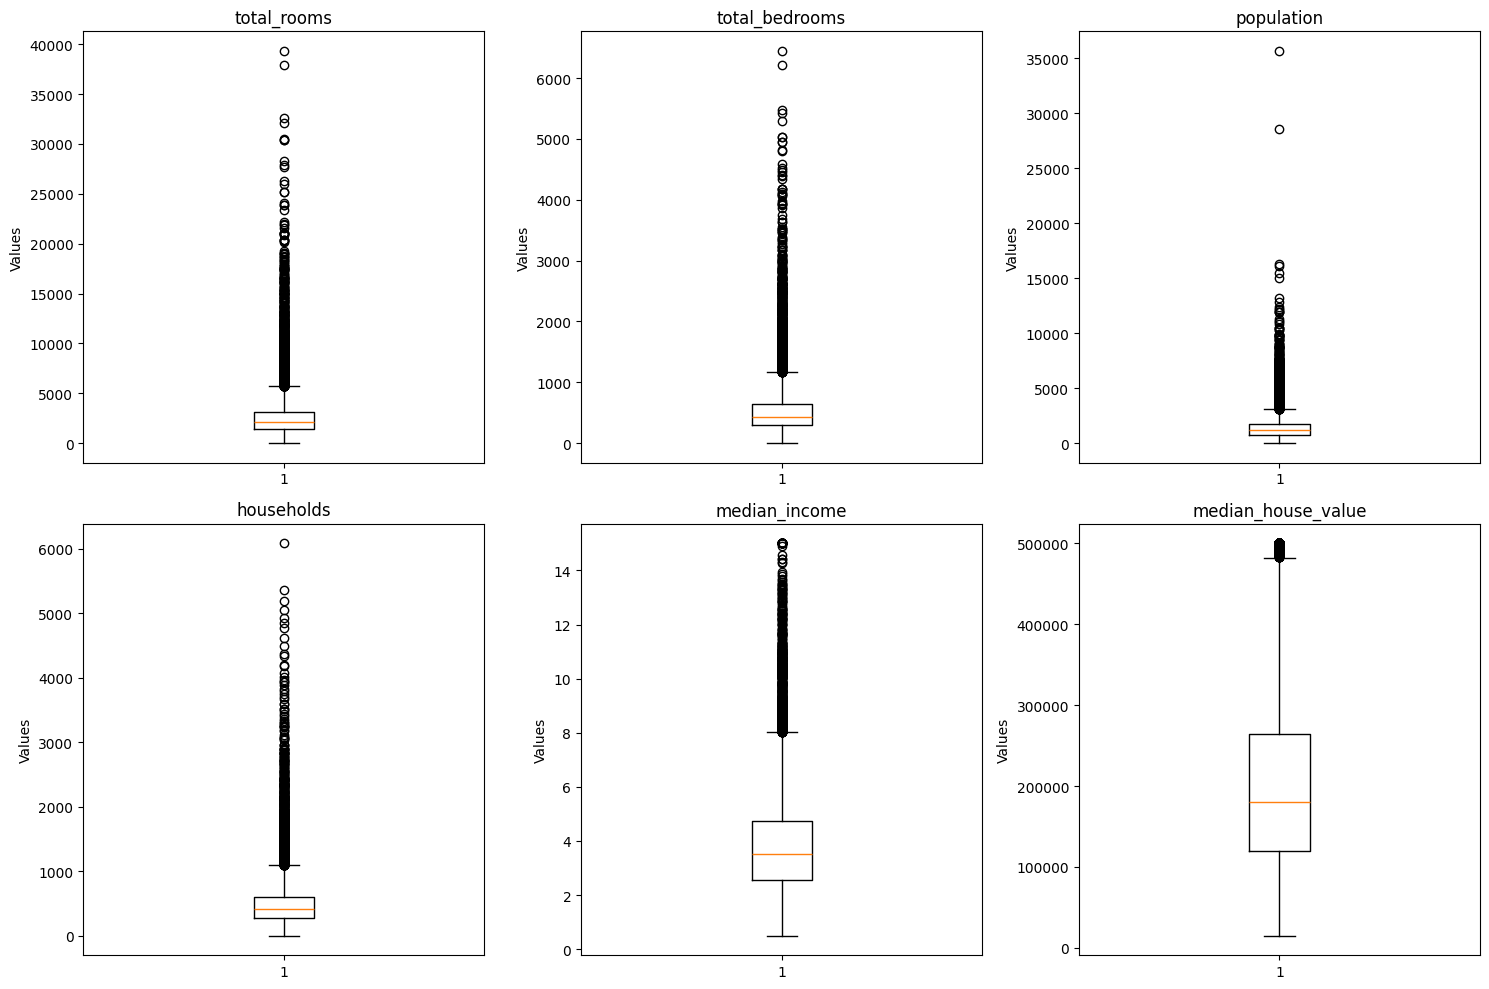

In [37]:
import matplotlib.pyplot as plt

features_with_outliers = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(features_with_outliers):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

### Это я типо умный и умею делать коробки с усами (графики выбросов)

### Очистка данных
Я выбрал **Z** очистку потому что патриотично

In [38]:
numerical_cols = [
    'longitude', 'latitude', 'housing_median_age', 'total_rooms', 
    'total_bedrooms', 'population', 'households', 'median_income'
]
target_col = 'median_house_value'

for i, col in enumerate(numerical_cols, 1):
    print(f"  {i}. {col}")

def remove_outliers_zscore(df, columns, z_threshold=3):
    df_clean = df.copy()
    outlier_indices = set()
    
    for col in columns:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
        z_scores = np.abs(stats.zscore(df_clean[col]))
        col_outliers = df_clean[z_scores > z_threshold].index
        outlier_indices.update(col_outliers)
        print(f"  {col}: найдено {len(col_outliers)} выбросов")
    
    df_clean = df_clean.drop(index=outlier_indices)
    removed_count = len(outlier_indices)
    print(f"\nИТОГО: Удалено {removed_count} строк ")
    
    nan_summary = df_clean[columns].isna().sum()
    if nan_summary.sum() == 0:
        print("\nПропусков не осталось во всех числовых столбцах.")
    else:
        print("\nОстались пропуски:")
        print(nan_summary[nan_summary > 0])
    
    return df_clean, removed_count

df_clean, removed_count = remove_outliers_zscore(df, numerical_cols, z_threshold=3)


  1. longitude
  2. latitude
  3. housing_median_age
  4. total_rooms
  5. total_bedrooms
  6. population
  7. households
  8. median_income
  longitude: найдено 0 выбросов
  latitude: найдено 0 выбросов
  housing_median_age: найдено 0 выбросов
  total_rooms: найдено 373 выбросов
  total_bedrooms: найдено 375 выбросов
  population: найдено 342 выбросов
  households: найдено 363 выбросов
  median_income: найдено 345 выбросов

ИТОГО: Удалено 894 строк 

Пропусков не осталось во всех числовых столбцах.


## Непосредственно ЖАДНЫЙ АЛГОРИТМ:

**ЖАДНЫЙ АЛГОРИТМ** - это эвристический метод оптимизации, который на каждом шаге выбирает локально оптимальное решение.

### ОСНОВНЫЕ СТРАТЕГИИ:

- **ПРЯМОЙ ОТБОР (Forward Selection)** - начинается с пустого набора, поочередно добавляет лучшие признаки
- **ОБРАТНЫЙ ОТБОР (Backward Elimination)** - начинается с полного набора, поочередно удаляет худшие признаки

### ЭТАПЫ ПРЯМОГО ОТБОРА:

1. **ИНИЦИАЛИЗАЦИЯ** - начинаем с пустого набора признаков
2. **ОЦЕНКА КАНДИДАТОВ** - для каждого доступного признака оцениваем качество модели при его добавлении
3. **ВЫБОР ЛУЧШЕГО** - выбираем признак, который максимально улучшает качество
4. **ОБНОВЛЕНИЕ НАБОРА** - добавляем выбранный признак к текущему набору
5. **УСЛОВИЕ ЗАВЕРШЕНИЯ** - повторяем шаги 2-4 пока качество улучшается или не достигнуто целевое количество признаков

### ЭТАПЫ ОБРАТНОГО ОТБОРА:

1. **ИНИЦИАЛИЗАЦИЯ** - начинаем с полного набора всех признаков
2. **ОЦЕНКА КАНДИДАТОВ** - для каждого текущего признака оцениваем качество модели при его удалении
3. **ВЫБОР ХУДШЕГО** - выбираем признак, удаление которого минимально ухудшает качество
4. **ОБНОВЛЕНИЕ НАБОРА** - удаляем выбранный признак из текущего набора
5. **УСЛОВИЕ ЗАВЕРШЕНИЯ** - повторяем шаги 2-4 пока качество не ухудшается или не достигнуто целевое количество признаков

### В НАШЕМ СЛУЧАЕ:

- Качество модели оценивается с помощью кросс-валидации и R² score
- На каждом шаге алгоритм выбирает локально оптимальное решение
- Процесс продолжается пока наблюдается улучшение качества

In [44]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)


X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y, test_size=0.2, random_state=42)

def greedy_feature_selection_poly(X_train, y_train, X_test, y_test):
    n_features = X_train.shape[1]
    remaining_features = list(range(n_features))
    selected_features = []
    best_score = -np.inf
    
    print("Жадный отбор признаков с полиномиальными признаками:")

    while remaining_features:
        scores = {}
        for feature in remaining_features:
            temp_features = selected_features + [feature]
            model = LinearRegression()
            model.fit(X_train[:, temp_features], y_train)
            y_pred = model.predict(X_test[:, temp_features])
            score = r2_score(y_test, y_pred)
            scores[feature] = score
        
        best_feature = max(scores, key=scores.get)
        best_feature_score = scores[best_feature]
        
        if best_feature_score > best_score:
            best_score = best_feature_score
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break
    
    print("\nИтоговый R²:", best_score)
    return selected_features, best_score

selected_features, best_score = greedy_feature_selection_poly(X_train, y_train, X_test, y_test)

Жадный отбор признаков с полиномиальными признаками:

Итоговый R²: 0.7101462639305154


**Вывод:**  
После применения жадного отбора признаков итоговый коэффициент детерминации (R²) составил **0.7101**. это показывает, что модель объясняет примерно 71% дисперсии целевой переменной.
